# 1. EEG Dataset Processing

## Run in Several Sections

- 1a EEG Dataset Load & Preprocessing [Jump To](#run-1a-eeg-dataset-load--preprocessing)
- 1b EEG Feature Extraction [Jump To](#run-1b-eeg-feature-extraction)
- 1c EEG Results Collation [Jump To](#run-1c-eeg-results-collation)




## Some Ref Links

- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io
- MNE-Python: https://mne.tools/stable/index.html
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- autoreject = 0.4.3
- specparam = 2.0.0rc3

# Imports & Utilities

In [1]:
# General imports
import os
import sys
import gc
import warnings

from datetime import datetime
from pprint import pprint
import time
import pickle
import random

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra
# from specparam import __version__ as specparam_version
# print('Current SpecParam version:', specparam_version)


# Processing Functions

## Raw EEG Load, Filtering Functions

In [2]:
# Function to get the raw EEG signal data
#

def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
                for warn in w:
                    print(f"Warning loading EEG data for subject {subject}: {warn.message}")
                    if eeg_dataset_raw.annotations is not None:
                        print('Removing Annotations')
                        boundary_idx = []
                        for i, desc in enumerate(eeg_dataset_raw.annotations.description):
                            if 'boundary' in desc.lower():
                                boundary_idx.append(i)
                        if boundary_idx:
                            eeg_dataset_raw.annotations.delete(boundary_idx)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = utils.get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [3]:
# Function to plot EEG Time Series & Save to PDF
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    # Time Range
    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        warnings.warn("Epoched data detected: plotting may not be accurate for all types.", UserWarning)
        return
        # signal, times = eeg_FIF.get_data(picks=channels)
        # times = eeg_FIF.times

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

In [4]:
# Function to save EEG data for a given subject
#

def save_EEG_for_subject(eeg_data, folder_path, subject_name, tag, epoched=False, format='fif', verbose=False):

    if epoched:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_epo.{format}')
    else:
        subject_results_file = os.path.join(folder_path, f'{subject_name}_{tag}_raw.{format}')

    if format == 'fif':
        eeg_data.save(subject_results_file, overwrite=False, verbose=verbose)
    elif format == 'set':
        mne.export.export_raw(subject_results_file, eeg_data, fmt='eeglab', overwrite=False, verbose=verbose)
    else:
        raise ValueError(f"Unsupported format: {format}")


In [10]:
# Function to filter the raw EEG signal data
#

def perform_EEG_filtering(params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_filtered = EEG_raw.copy()

    # -----------------------------------------------------------------------
    # Bandpass filtering
    #
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=params['band_pass_lf'], 
                                       h_freq=params['band_pass_hf'], 
                                       method=params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # -----------------------------------------------------------------------
    # Montage Set
    # Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage("standard_1020")
    
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    missing_in_montage = raw_set - montage_set  
    EEG_filtered.drop_channels(missing_in_montage)

    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)

    # -----------------------------------------------------------------------
    # Remove linear trends from each channel signal & average
    #
    if params['linear_detrend'] != 'none':
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, 
                                    channel_wise=True, 
                                    type=params['linear_detrend'], 
                                    verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=params['channel_referencing'], verbose=flag_verbose)

    if flag_verbose:
        # std_1020_montage.plot()
        print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
        print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
        print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
        # fig = EEG_filtered.plot_sensors(show_names=True)
        # plt.show()

    return EEG_filtered


## Artefact Removal

In [11]:
# Function to perform artifact removal using ICA etc
#

def perform_artefact_removal(params, EEG_raw):
    """
    Artefact removal on the EEG raw data, using ICA

    Parameters
    ----------
    params : dic
    EEG_raw : raw

    Returns
    -------
    results : pd series
    epochs_ar : fif
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()
    quality_warning = False

    # -----------------------------------------------------------------------
    # Determine ICA components, label & identify for exclusion
    #

    # ICA & filter
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)
 
    ica_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ica_labels["labels"]
    brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    other_components = [i for i, label in enumerate(labels) if label != "brain"]
    filtered_ica = ica.apply(EEG_cleaned.copy(), exclude=np.unique(other_components), verbose=flag_verbose)

    # Flag 'quality'
    ICA_rejection_level = len(other_components)/ica.n_components_
    if ICA_rejection_level >= params['ICA_rejection_threshold']:
        warnings.warn(f"High component rejection: {100 * ICA_rejection_level:.2f}% marked as non-brain.", UserWarning)
        quality_warning = True

    if flag_verbose:
        print('ICA Components Breakdown')
        print(f'Original Channels: {len(EEG_cleaned.ch_names)}. ICA Components: {ica.n_components_}')
        print(f'Brain Components: {len(brain_components)}, {100 * len(brain_components)/ica.n_components_:.2f}%')
        print(f'Other Components: {len(other_components)}, {100 * len(other_components)/ica.n_components_:.2f}%')
        print(f'List of Brain components: {brain_components}')

        # Show the explained variance for top 5 components
        for component_idx in range(min(5, ica.n_components_)):
            component_variance = ica.get_explained_variance_ratio(EEG_cleaned, components=component_idx)
            print(f"Component {component_idx} contribution:", end=' ')
            for ch_type, variance in component_variance.items():
                print(f"  {ch_type}: {100 * variance:.2f}%")

        # ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")

    # -----------------------------------------------------------------------
    # Epoching & identify epochs for rejection
    #

    # Group the EEG signal into epochs and apply linear detrending
    epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0, preload=True, verbose=flag_verbose)
    epochs.apply_function(sci.signal.detrend, type='linear', verbose=flag_verbose)

    # Use autoreject to identify unusual large amplitudes in each epoch, drop these
    reject_criteria = get_rejection_threshold(epochs, verbose=flag_verbose)
    epochs.drop_bad(reject=reject_criteria, verbose=False)

    # Instantiate AutoReject and clean individual segments
    epochs_ar, reject_log = ar_model.fit_transform(epochs, return_log=True)
    epochs_ar.pick(['eeg'])
    n_epochs_rejected = np.sum(reject_log.bad_epochs)
    epochs_rejection_level = n_epochs_rejected / len(epochs)
    
    if flag_verbose:
        print(f'Epochs rejected: {n_epochs_rejected} out of {len(epochs)}, {100 * epochs_rejection_level:.2f}%')
        # TODO: Are these plots really of much use?
        # Epochs plot rejection patterns
        reject_log.plot('horizontal')
        # Before and After
        epochs.average().plot() 
        epochs_ar.average().plot() 

        print('EEG Post Artifact Removal')
        print(epochs_ar)

    # -----------------------------------------------------------------------
    # Collate results
    #
    results = pd.Series({
        'EEG_processing_quality_warning': quality_warning,
        'channel_count': len(EEG_raw.ch_names),
        'ICA_components_count': ica.n_components_,
        'ICA_rejection_level': ICA_rejection_level,
        'epochs_count': len(epochs),
        'epoch_rejection_level': epochs_rejection_level
        })
    
    return results, epochs_ar


# Run: 1a EEG Dataset Load & Preprocessing

In [6]:
# Run Details & Parameters
#

# Study Details
study_name = 'IOWA_Rest'

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Run Name & Test Mode
test_mode = True
run_description = 'sample_test'

# Preprocessing Parameters for this run
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 
                     'band_pass_method': 'iir', 'phase': 'zero',
                     'linear_detrend': 'linear',  # linear, none
                     'channel_referencing': 'average' 
                     }
artefact_params = {'ica_method': 'infomax', # infomax, none
                   'ICA_rejection_threshold': 0.8
                    }

# Setup the processing run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'1a_EEG_Preprocessing_Results_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['eeg_processing_results_path'], run_name, exists_ok=False)
run_details = pd.Series({
    'run_name': run_name,
    'study_name': study_name,
    'preprocess_params': preprocess_params,
    'artefact_params': artefact_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    test_subjects = [0] # [0,5,101]
    test_channels = ['F4', 'C5', 'Cz', 'P6']
else:
    VERBOSE = False
    test_subjects = []
    test_channels = []
    
del current_date, study_name, run_description, study_folder_path


EEG Preprocessing
- Study: IOWA_Rest ds004584-1.0.0
- Run: 1a_EEG_Preprocessing_Results_20250702_sample_test
- Preprocessing Params: {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir', 'phase': 'zero', 'linear_detrend': 'linear', 'channel_referencing': 'average'}
- Artefact Removal Params: {'ica_method': 'infomax', 'ICA_rejection_threshold': 0.8}

-----------------------------------------------------------------------------------------------
Subject: sub-001
---Get EEG Raw Data - FIF -----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Warning loading EEG data for subject sub-001: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Removing Annotations
Description: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt,

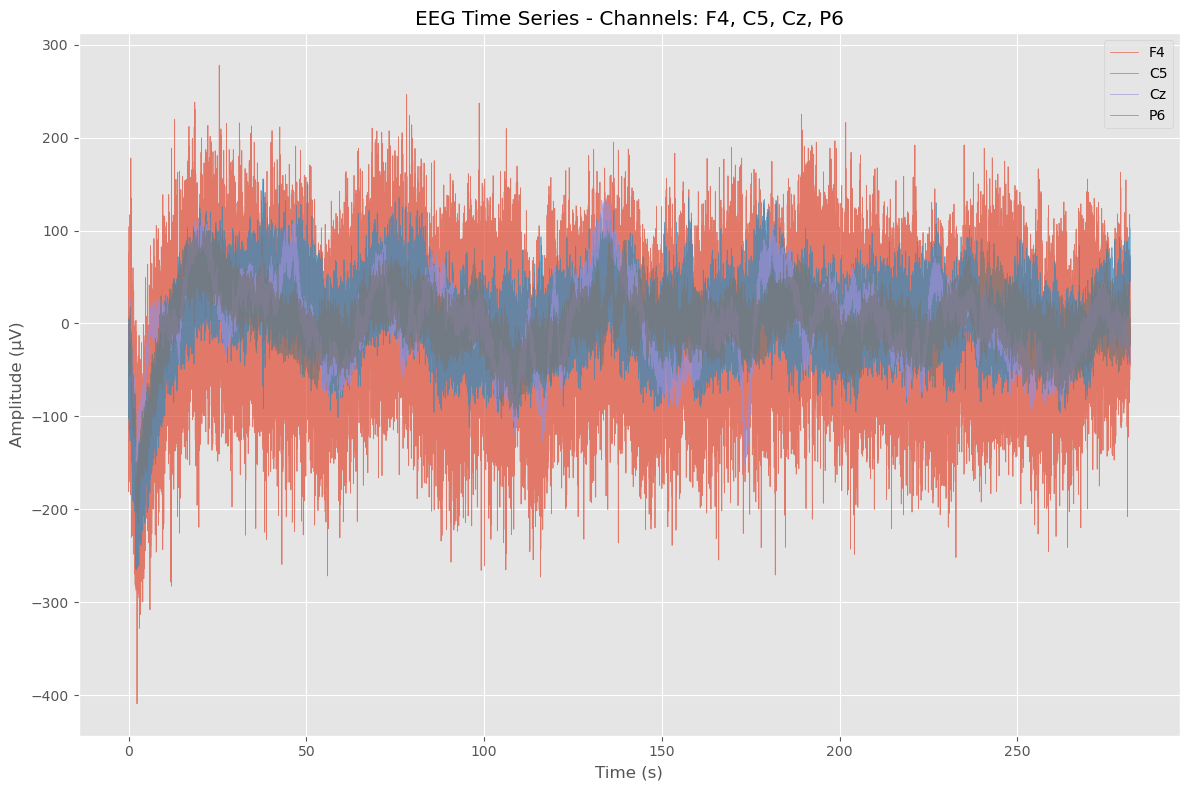

---Filtering & Referencing------------------------------------------
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.2s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Channels in montage but not in EEG_raw: ['A1', 'A2', 'AF1', 'AF10', 'AF2', 'AF5', 'AF6', 'AF9', 'F10', 'F9', 'Fpz', 'Iz', 'M1', 'M2', 'O10', 'O9', 'P10', 'P9', 'PO1', 'PO10', 'PO2', 'PO5', 'PO6', 'PO9', 'Pz', 'T10', 'T3', 'T4', 'T5', 'T6', 'T9']
Channels in EEG_raw but not in montage: []
Number of channels before: 63 and after montage set: 63


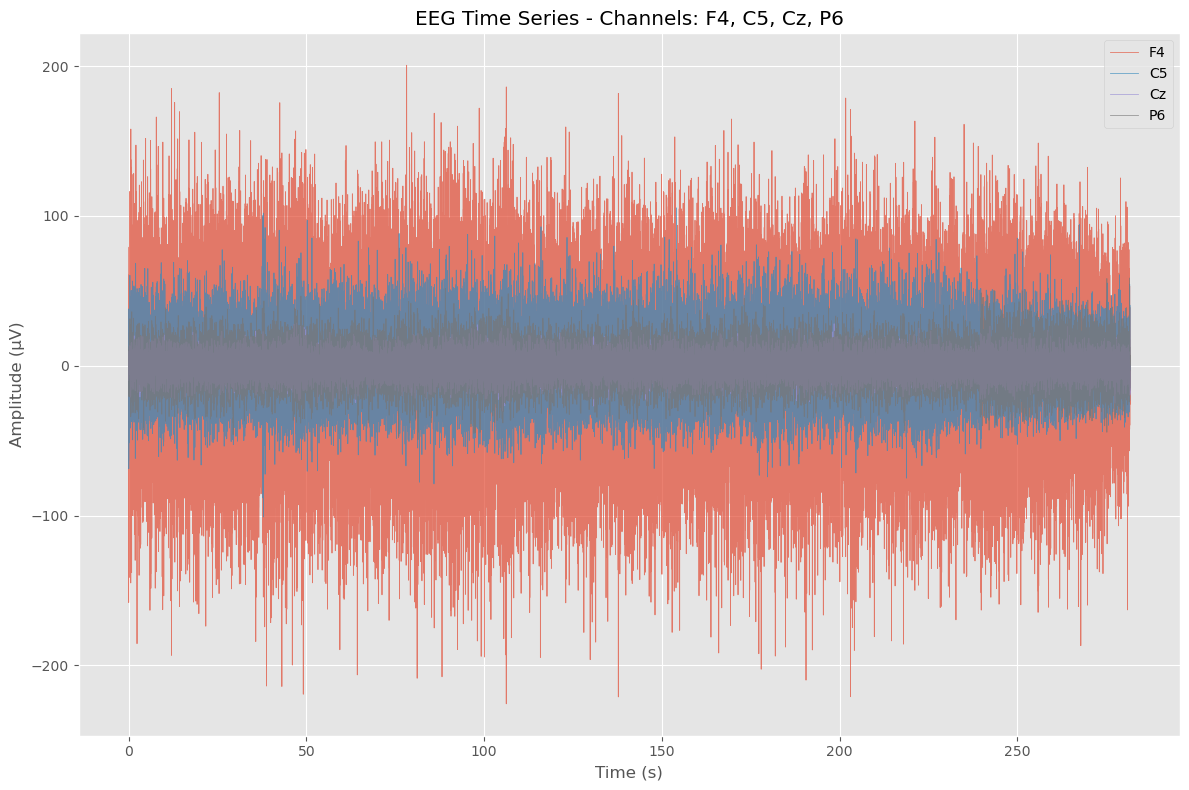

---Artefact Removal - ICA ------------------------------------------
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 62 components
Computing Extended Infomax ICA


In [ ]:
# Run all the steps for EEG preprocessing
#

# Start Trace
summary = f'EEG Preprocessing'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- Run: {run_details['run_name']}"
summary = summary + f"\n- Preprocessing Params: {preprocess_params}"
summary = summary + f"\n- Artefact Removal Params: {artefact_params}"
print(summary)

# Loop through all selected subjects in the study
for idx, subject in study_subjects_df.iterrows():

    # Just sample a subset of subjects when in test mode
    if test_mode and idx not in test_subjects:
        continue

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f'Subject: {subject_id}')

    # 1. EEG Raw Dataset Load
    #
    print('---Get EEG Raw Data - FIF -----------------------------------------')
    EEG_raw_files = get_EEG_raw(study_info['dataset_path'], subject_id)
    # TODO: How to handle multiple session EEG raw files?
    EEG_raw = EEG_raw_files[0]

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_1_raw_files')
    save_EEG_for_subject(EEG_raw, save_folder_path, subject_id, tag='source')

    if VERBOSE:
        print(f"Description: {EEG_raw.info['description']} on {EEG_raw.info['meas_date']}")
        print(EEG_raw)
        print(EEG_raw.info)
        plot_EEG_TD(EEG_raw, test_channels)
    
    # 2. EEG Filtering & Referencing
    #
    print('---Filtering & Referencing------------------------------------------')
    EEG_filtered = perform_EEG_filtering(preprocess_params, EEG_raw)

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_2_cleaned_files')
    save_EEG_for_subject(EEG_filtered, save_folder_path, subject_id, tag='filtered')

    if VERBOSE:
        plot_EEG_TD(EEG_filtered, test_channels)

    # 3. Artefact Removal with ICA etc
    #
    print('---Artefact Removal - ICA ------------------------------------------')
    artefact_results, EEG_cleaned = perform_artefact_removal(artefact_params, EEG_filtered)

    save_folder_path = utils.extend_folder_path(run_results_path, 'EEG_2_cleaned_files')
    save_EEG_for_subject(EEG_cleaned, save_folder_path, subject_id, tag='preprocessed')

    if VERBOSE:
        # TODO: Any need to summarise or retain results?
        # TODO: Correct plot for Epoched data
        plot_EEG_TD(EEG_cleaned, test_channels)
        print(f'Temp .... {EEG_cleaned}, \n{artefact_results}')



# Run: 1b EEG Feature Extraction

# Run: 1c EEG Results Collation